In [1]:
import math
import random
import time
from jupyterthemes import jtplot
jtplot.style()

import gym
gym.logger.set_level(40)
import numpy as np


import nnabla as nn
import nnabla.logger as logger
import nnabla.functions as F
import nnabla.parametric_functions as PF
import nnabla.solver as S
from nnabla.contrib.context import extension_context
from nnabla.monitor import Monitor, MonitorSeries, MonitorTimeElapsed

2018-08-12 01:08:11,853 [nnabla][INFO]: Initializing CPU extension...


In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [4]:
from collections import deque
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [5]:
env = gym.make("CartPole-v0")
state_num = env.observation_space.shape[0]
action_num = env.action_space.n

hidden_size = 128
max_frames = 20000
state_size = 1
batch_size = 32
replay_buffer_size = 1000
gamma = 0.99
learning_rate = 1e-3

In [6]:
"""
class DQN:
    def __init__(self, num_states, num_actions):
        self.state_dim = num_states
        self.action_dim = num_actions 
        self.state = nn.Variable([state_size, self.state_dim])
    
    def compute_Q(self, x):
        with nn.parameter_scope("DQN"):
            with nn.parameter_scope("affine1"):
                h = F.relu(PF.affine(x, hidden_size))
            with nn.parameter_scope("affine2"):
                h = F.relu(PF.affine(h, hidden_size))
            with nn.parameter_scope("affine3"):
                y = PF.affine(h, self.action_dim)
        return y
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            self.state.d = state
            q_value = self.compute_Q(self.state)
            print("q_value.d",q_value.d)
            action  = np.argmax(q_value.d)
#            print("action:",action)
        else:
            action = random.randrange(self.action_dim)
        return action
"""

'\nclass DQN:\n    def __init__(self, num_states, num_actions):\n        self.state_dim = num_states\n        self.action_dim = num_actions \n        self.state = nn.Variable([state_size, self.state_dim])\n    \n    def compute_Q(self, x):\n        with nn.parameter_scope("DQN"):\n            with nn.parameter_scope("affine1"):\n                h = F.relu(PF.affine(x, hidden_size))\n            with nn.parameter_scope("affine2"):\n                h = F.relu(PF.affine(h, hidden_size))\n            with nn.parameter_scope("affine3"):\n                y = PF.affine(h, self.action_dim)\n        return y\n    \n    def act(self, state, epsilon):\n        if random.random() > epsilon:\n            self.state.d = state\n            q_value = self.compute_Q(self.state)\n            print("q_value.d",q_value.d)\n            action  = np.argmax(q_value.d)\n#            print("action:",action)\n        else:\n            action = random.randrange(self.action_dim)\n        return action\n'

In [7]:
def DQN(state):
    with nn.parameter_scope("DQN"):
        with nn.parameter_scope("affine1"):
            h = F.relu(PF.affine(state, hidden_size))
        with nn.parameter_scope("affine2"):
            h = F.relu(PF.affine(h, hidden_size))
        with nn.parameter_scope("affine3"):
            Q = PF.affine(h, action_num)
    return Q

def act(state, epsilon):
    if random.random() > epsilon:
        State.d = state
        Q.forward()
        action  = np.argmax(Q.d)
#        print("q_value.d",Q.d[0])
    else:
        action = random.randrange(action_num)
    return action

In [8]:
replay_buffer = ReplayBuffer(replay_buffer_size)

#変数定義
State = nn.Variable([32, 4])
Q = DQN(State)
t = nn.Variable([32, 2])
#損失関数定義
loss = F.squared_error(Q, t)

#solver定義
solver = S.Adam(learning_rate)
with nn.parameter_scope("DQN"):
    solver.set_parameters(nn.get_parameters())
solver.zero_grad()

losses = []
overall_rewards = []
episode_reward = 0

In [9]:
"""
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    State = nn.Variable.from_numpy_array(state)
    Next_State = nn.Variable.from_numpy_array(next_state)
    Action = nn.Variable(action)
    Reward = nn.Variable(reward)
    Done = nn.Variable(done)
#    print("action",action)
    
    q_values = DQN(State)
#    print("q_values.d",q_values.d)
    q_values = np.array([q_values.d[i,action[i]] for i in range(batch_size)])
#    print("q_values",q_values)

    next_q_values = DQN(Next_State)
#    print("next_q_values.d",next_q_values.d)
    next_q_values = next_q_values.d.max(axis=1)
#    print("next_q_values", next_q_values)
    reward = np.array(reward)
    done = np.array(done)
#    print("Reward",reward)
#    print("next_q_value",next_q_values)
    expected_q_value = reward + gamma * next_q_values * (1 - done)
#    print("type",type(q_values),type(expected_q_value))
    q_values = nn.Variable.from_numpy_array(q_values)
    expected_q_value = nn.Variable.from_numpy_array(expected_q_value)
#    print(q_values,expected_q_value)
    DQN_loss = F.squared_error(q_values, expected_q_value)
    DQN_loss.forward()
    DQN_solver.zero_grad()
    DQN_loss.backward()
    DQN_solver.update()

    return DQN_loss
"""

'\ndef compute_td_loss(batch_size):\n    state, action, reward, next_state, done = replay_buffer.sample(batch_size)\n    State = nn.Variable.from_numpy_array(state)\n    Next_State = nn.Variable.from_numpy_array(next_state)\n    Action = nn.Variable(action)\n    Reward = nn.Variable(reward)\n    Done = nn.Variable(done)\n#    print("action",action)\n    \n    q_values = DQN(State)\n#    print("q_values.d",q_values.d)\n    q_values = np.array([q_values.d[i,action[i]] for i in range(batch_size)])\n#    print("q_values",q_values)\n\n    next_q_values = DQN(Next_State)\n#    print("next_q_values.d",next_q_values.d)\n    next_q_values = next_q_values.d.max(axis=1)\n#    print("next_q_values", next_q_values)\n    reward = np.array(reward)\n    done = np.array(done)\n#    print("Reward",reward)\n#    print("next_q_value",next_q_values)\n    expected_q_value = reward + gamma * next_q_values * (1 - done)\n#    print("type",type(q_values),type(expected_q_value))\n    q_values = nn.Variable.from_

In [10]:
def compute_td_loss(batch_size):
    global State, Q, t, loss
    #リプレイサンプル
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    #変数代入
    State.d = state
    t.d = np.full((32,2),-100.0)
    
    loss.forward()
    solver.zero_grad()
    loss.backward()
    solver.update()
#    print("DQN_loss",loss.d)
#    Q = DQN(State)
#    print("Q1 :",Q.d)
#    Q.forward()
#    print("Q2 :",Q.d)
    return loss
"""
    q_values = DQN(State)
    q_values = np.array([q_values.d[i,action[i]] for i in range(batch_size)])
    next_q_values = DQN(Next_State)
    next_q_values = next_q_values.d.max(axis=1)
    reward = np.array(reward)
    done = np.array(done)
    expected_q_value = reward + gamma * next_q_values * (1 - done)
    q_values = nn.Variable.from_numpy_array(q_values)
    expected_q_value = nn.Variable.from_numpy_array(expected_q_value)

    DQN_loss = F.squared_error(q_values, expected_q_value)
    DQN_loss.forward()
    DQN_solver.zero_grad()
    DQN_loss.backward()
    DQN_solver.update()
"""

'\n    q_values = DQN(State)\n    q_values = np.array([q_values.d[i,action[i]] for i in range(batch_size)])\n    next_q_values = DQN(Next_State)\n    next_q_values = next_q_values.d.max(axis=1)\n    reward = np.array(reward)\n    done = np.array(done)\n    expected_q_value = reward + gamma * next_q_values * (1 - done)\n    q_values = nn.Variable.from_numpy_array(q_values)\n    expected_q_value = nn.Variable.from_numpy_array(expected_q_value)\n\n    DQN_loss = F.squared_error(q_values, expected_q_value)\n    DQN_loss.forward()\n    DQN_solver.zero_grad()\n    DQN_loss.backward()\n    DQN_solver.update()\n'

In [11]:
def plot(frame, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

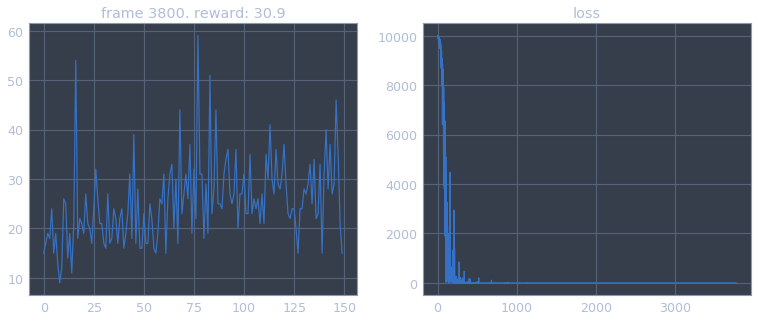

In [ ]:
state = env.reset()
nn.clear_parameters()
for frame in range(1, max_frames):
    epsilon = epsilon_by_frame(frame)
    action = act(state, epsilon)
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    state = next_state
    episode_reward += reward   
#    env.render()
    if done:
        state = env.reset()
        overall_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(np.average(loss.d[0]))
    if frame % 200 == 0:
        plot(frame, overall_rewards, losses)